In [188]:
import utils.file_utils as fu
import perceptrons.multilayer_perceptron as mlp
import numpy as np
import metrics as m
import graphing as g
import matplotlib.pyplot as plt

In [189]:
config_file_path = "ex_2/resources/config.json"
config_file = fu.parse_config(config_file_path)

path_to_data = config_file["path_to_data"]
epoch_limit = int(config_file["epoch_limit"])
execution_count = int(config_file["execution_count"])
momentum = bool(config_file["momentum"])
cross_validation_k = int(config_file["cross_validation"])
learn_rate = float(config_file["learn_rate"])
adaptive_learn_rate = bool(config_file["adaptive_learn_rate"])
if adaptive_learn_rate:
    update_learn_rate = (lambda lr, k: lr + 0.3 if k >= 3 else (lr - lr*0.1 if k <=-3 else 0)) 
else:
    update_learn_rate = None
if config_file["activation_function"] == "linear":
    activation_function = (lambda x: x)
    activation_derivative = (lambda x: 1)
elif config_file["activation_function"] == "sigmoid":
    activation_function = (lambda x: 1/(1+np.exp(-2*x)))
    activation_derivative = (lambda x: 2*(1/(1+np.exp(-2*x)))*(1-(1/(1+np.exp(-2*x)))) )


In [190]:
training, expected = fu.parse_training_set_from_file(path_to_data)
p = mlp.MultiLayerPerceptron(learning_rate=learn_rate, hidden_layers=[], input_dim=len(training[0]), output_dim=len(expected[0]), update_frequency=0, activation_function=activation_function, activation_function_derivative=activation_derivative, update_learn_rate=update_learn_rate, scale_output=True,momentum=momentum)

In [191]:

open(path_to_data+"/error_vs_iteration.txt", "w").close()
p.train(training, expected, epoch_limit, callback=(lambda e, error, weights, output: fu.write_error_vs_iteration(path_to_data, error, e)))

({0: array([[-0.24694911],
         [ 0.25324159],
         [ 0.25324387],
         [ 0.25317242]])},
 2.952449099101706e-06)

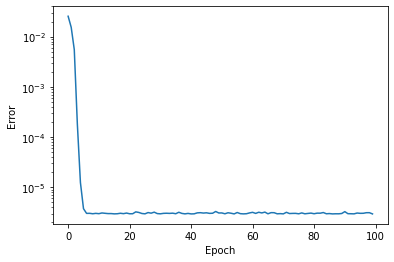

In [192]:
g.error_vs_iteration(path_to_data, True)

In [193]:
def get_accuracy(real_output, expected_output, precision):
    counter =0
    for i in range(len(real_output)):
        if np.abs(np.subtract(real_output[i], expected_output[i])) < precision:
            counter += 1
    return counter/len(real_output)

def callback_fun(e, error, weights, output, entries, expected_output, test_group, test_output, i=None):
    test_err = p.test_network(test_group, test_output)
    test_results = [p.forward_propagation(item) for item in test_group]
    entries_results = [p.forward_propagation(item) for item in entries]
    normalized_test_output = [p.normalize_output(item) for item in test_output]
    normalized_output = [p.normalize_output(item) for item in expected_output]
    test_acc = get_accuracy(normalized_test_output, test_results, 0.001)
    train_acc = get_accuracy(normalized_output, entries_results, 0.001)
    if i is not None:
        f = open(path_to_data+"/generalization_error_{}.txt".format(i), "a")
    else:
        f = open(path_to_data+"/generalization_error.txt", "a")
    f.write("{},{},{},{},{}\n".format(e, error, test_err[0], test_acc, train_acc))
    f.close()


In [194]:
open(path_to_data+"/generalization_error.txt", "w").close()
entries, expected = m.cross_validation(training, cross_validation_k, expected)
i = np.random.randint(len(entries))
t = entries[:i] + entries[i+1:]
training_set = [item for sublist in t for item in sublist]
e = expected[:i] + expected[i+1:]
expected_set = [item for sublist in e for item in sublist]
p.train(training_set, expected_set, epoch_limit, 
callback=(lambda e, error, weights, output: callback_fun(e, error, weights, output,training_set, expected_set, entries[i], expected[i])))


({0: array([[-0.24687286],
         [ 0.25326188],
         [ 0.25295398],
         [ 0.25363041]])},
 3.0267099827847982e-06)

In [195]:
f = open(path_to_data+"/generalization_error.txt", "r")
lines = f.readlines()
epochs = []
errors = []
test_errors = []
train_accs =[]
test_accs = []
for line in lines:
    e, error, test_err, test_acc, train_acc = line.split(",")
    epochs.append(int(e))
    errors.append(float(error))
    test_errors.append(float(test_err))
    train_accs.append(float(train_acc))
    test_accs.append(float(test_acc))
f.close()


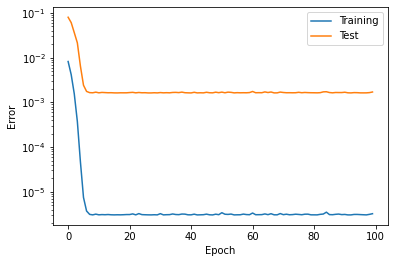

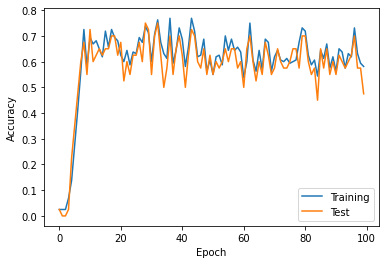

In [196]:
plt.figure(1)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.yscale("log")
plt.plot(epochs, errors, label="Training")
plt.plot(epochs, test_errors, label="Test")
plt.legend()
plt.figure(2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# plt.yscale("log")
plt.plot(epochs, train_accs, label="Training")
plt.plot(epochs, test_accs, label="Test")
plt.legend()

In [197]:
if config_file["activation_function"] == "sigmoid":
    training, expected = fu.parse_training_set_from_file(path_to_data)
    p = mlp.MultiLayerPerceptron(learning_rate=learn_rate, hidden_layers=[], 
    input_dim=len(training[0]), output_dim=len(expected[0]), update_frequency=0, activation_function=activation_function, 
    activation_function_derivative=activation_derivative, update_learn_rate=update_learn_rate, scale_output=True,momentum=momentum)
    training_groups, expected_groups = m.cross_validation(training,cross_validation_k,expected)
    test_err_min = None
    train_err_min = None
    test_prec_max = None
    train_prec_max = None
    for i, test_group in enumerate(training_groups):
        errors =[]
        t = training_groups[:i] + training_groups[i+1:]
        training_set = [item for sublist in t for item in sublist]
        e = expected_groups[:i] + expected_groups[i+1:]
        expected_set = [item for sublist in e for item in sublist]
        w, err = p.train(training_set, expected_set, epoch_limit, 
        callback=(lambda e, error, weights, output: callback_fun(e, error, weights, output,training_set, expected_set, training_groups[i], expected_groups[i], i)))

        # test_err = p.test_network(test_group, expected_groups[i])
        # test_results = [p.forward_propagation(item) for item in test_group]
        # entries_results = [p.forward_propagation(item) for item in training_set]
        # normalized_test_output = [p.normalize_output(item) for item in expected_groups[i]]
        # normalized_output = [p.normalize_output(item) for item in expected_set]
        # test_acc = get_accuracy(normalized_test_output, test_results, 0.001)
        # train_acc = get_accuracy(normalized_output, entries_results, 0.001)
        # f = open(path_to_data+"/generalization_error.txt", "a")
        # f.write("{},{},{},{},{}\n".format(e, error, test_err[0], test_acc, train_acc))
        # f.close()
        # Test
        # for j, test_entry in enumerate(test_group):
        #     prediction = p.forward_propagation(test_entry)
        #     expected_output = expected_groups[i][j]
        #     errors.append(np.abs(np.subtract(prediction , expected_output)))

        # mean_error = m.mean_error(errors)
        # max_error = m.max_error(errors)
        # min_error = m.min_error(errors)
        # mse_error = m.mse(errors)
        # rmsd_error = m.rmsd(errors)
        # if train_err_min == None or err < train_err_min:
        #     train_err_min = err
        # if test_err_min == None or test_err_min < test_err:
        #     test_err_min = test_err
        # if test_prec_max == None or test_prec_max > test_acc:
        #     test_prec_max = test_acc
        # if train_prec_max == None or train_prec_max > train_acc:
        #     train_prec_max = train_acc

   


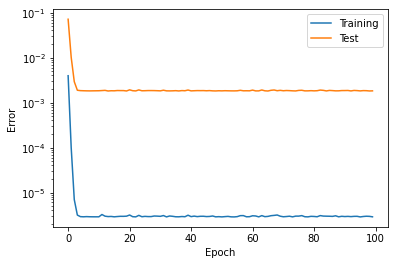

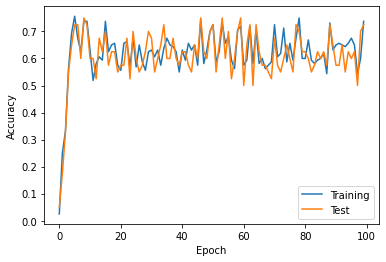

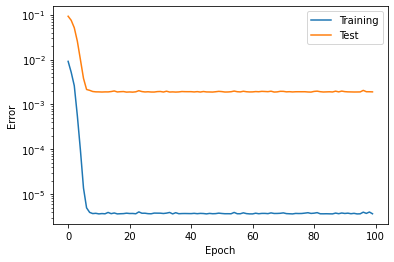

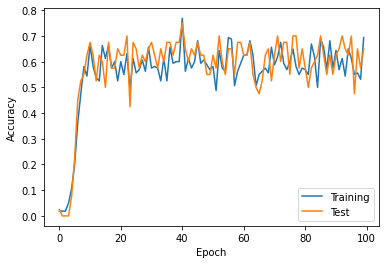

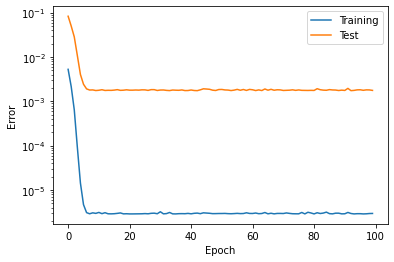

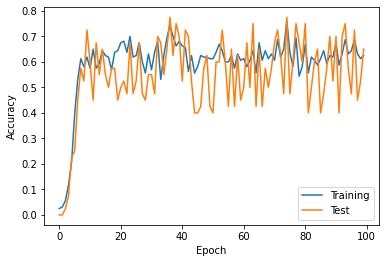

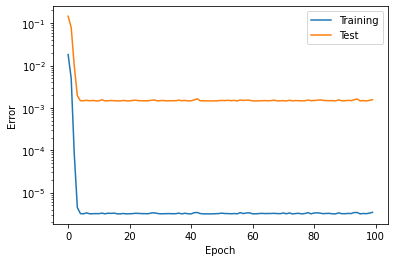

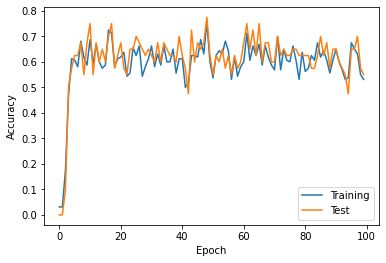

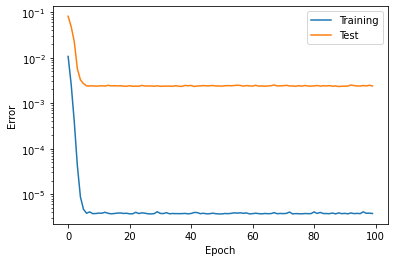

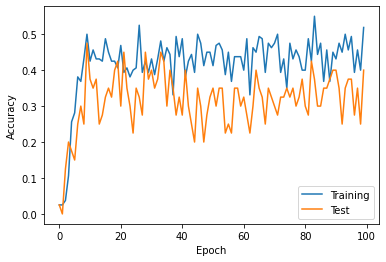

In [200]:
j=1
for i in range(len(training_groups)):
    f = open(path_to_data+"/generalization_error_{}.txt".format(i), "r")
    lines = f.readlines()
    epochs = []
    errors = []
    test_errors = []
    train_accs =[]
    test_accs = []
    for line in lines:
        e, error, test_err, test_acc, train_acc = line.split(",")
        epochs.append(int(e))
        errors.append(float(error))
        test_errors.append(float(test_err))
        train_accs.append(float(train_acc))
        test_accs.append(float(test_acc))
    f.close()
    plt.figure(j)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.plot(epochs, errors, label="Training")
    plt.plot(epochs, test_errors, label="Test")
    plt.legend()
    plt.figure(j+1)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    # plt.yscale("log")
    plt.plot(epochs, train_accs, label="Training")
    plt.plot(epochs, test_accs, label="Test")
    plt.legend()
    j+=2
    